In [10]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load data
df = pd.read_csv('chronic_kidney_disease.csv')
df.replace('?', np.nan, inplace=True)

# 2. Cek Kolom Target
target_col = 'classification' if 'classification' in df.columns else 'class'

# 3. Mapping Data Kategori ke Angka
map_data = {"yes": 1, "no": 0, "normal": 1, "abnormal": 0, "present": 1, "notpresent": 0, "good": 1, "poor": 0, "ckd": 1, "notckd": 0}
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str).str.strip().str.lower().map(map_data)

# 4. Imputasi (Isi data kosong dengan median)
df = df.apply(pd.to_numeric, errors='coerce')
df = df.fillna(df.median())

# 5. Seleksi Fitur
kolom_fitur = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 
                'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 
                'dm', 'cad', 'appet', 'pe', 'ane']
X = df[kolom_fitur]
y = df[target_col]

# 6. Split & Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Simpan Scaler (Hanya butuh 1 scaler untuk semua model)
pickle.dump(scaler, open('scaler.pkl', 'wb'))
print("✅ Tahap 1 Selesai: Data siap dan Scaler disimpan.")

✅ Tahap 1 Selesai: Data siap dan Scaler disimpan.


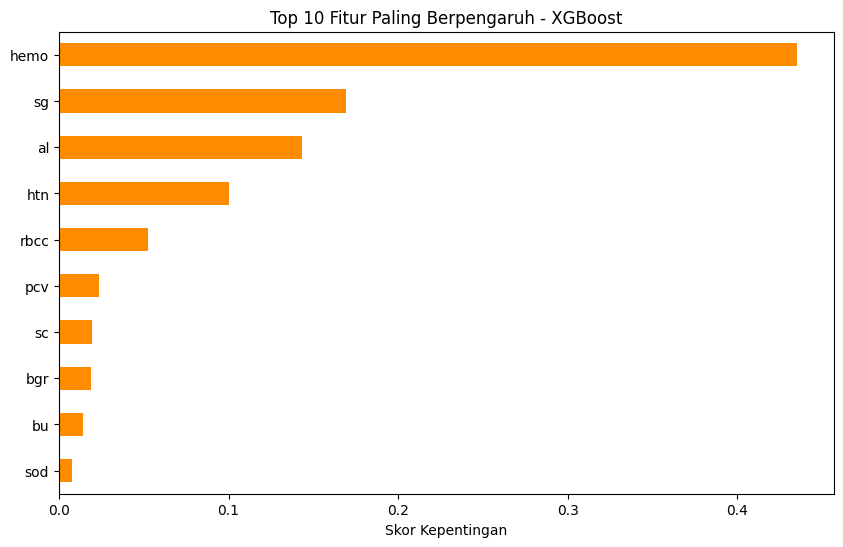

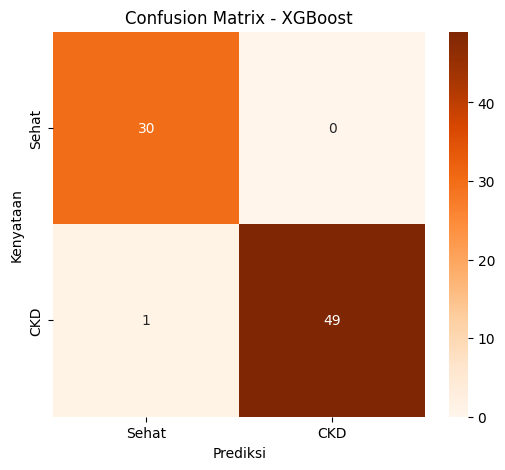

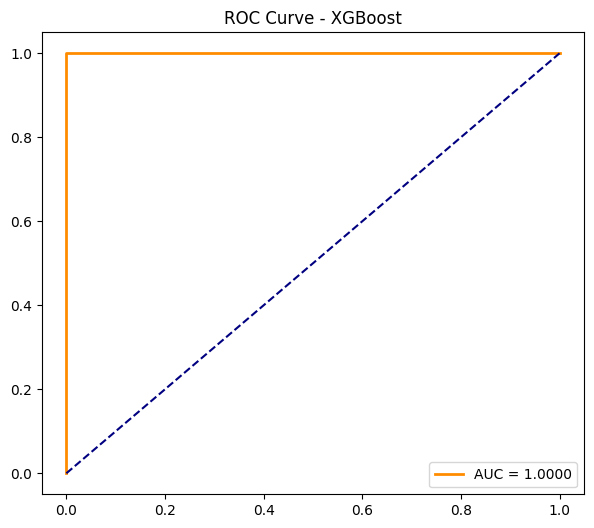

✅ Berhasil! Akurasi XGBoost: 98.75%


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 1. Pastikan Model di-Training Ulang (Agar Segar di Memori)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# 2. Ambil Prediksi dan Probabilitas
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# --- VISUALISASI 1: FEATURE IMPORTANCE ---
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(xgb_model.feature_importances_, index=kolom_fitur)
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='darkorange')
plt.title('Top 10 Fitur Paling Berpengaruh - XGBoost')
plt.xlabel('Skor Kepentingan')
plt.show()

# --- VISUALISASI 2: CONFUSION MATRIX ---
plt.figure(figsize=(6, 5))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', xticklabels=['Sehat', 'CKD'], yticklabels=['Sehat', 'CKD'])
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Kenyataan')
plt.xlabel('Prediksi')
plt.show()

# --- VISUALISASI 3: ROC CURVE ---
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(7, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'AUC = {roc_auc_xgb:.4f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()

print(f"✅ Berhasil! Akurasi XGBoost: {xgb_model.score(X_test_scaled, y_test):.2%}")

c:\KULIAH\MATA KULIAH SEMESTER 5\PEMBELAJARAN MESIN\PREDIKSI GINJAL KRONIS\venv\Lib\site-packages\xgboost\plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


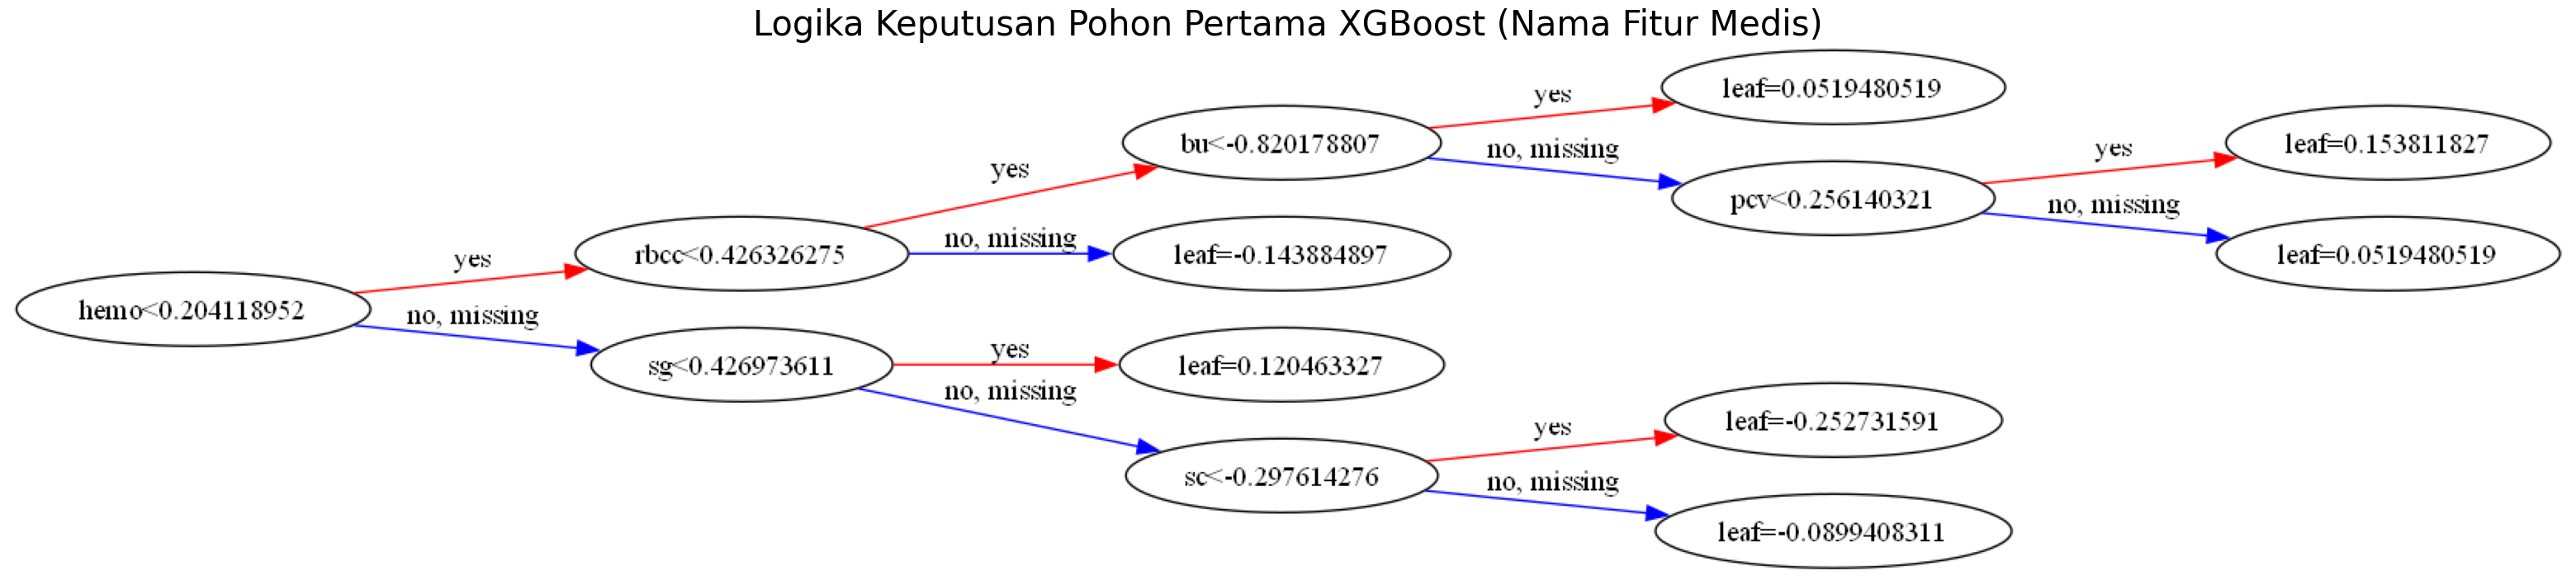

✅ Visualisasi tambahan berhasil dibuat! Cek file 'pohon_keputusan_jelas.png' di folder kamu.


In [12]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from xgboost import plot_tree
import matplotlib.pyplot as plt


# --- 2. VISUALISASI POHON KEPUTUSAN (HD & BERLABEL) ---
# Kita kasih tahu modelnya nama kolom aslinya supaya tidak muncul f0, f1, f2
xgb_model.get_booster().feature_names = list(kolom_fitur)

# Buat ukuran super besar (40x20) supaya tulisan di dalam kotak terbaca
fig, ax = plt.subplots(figsize=(40, 20))

# Plot pohon pertama (index 0)
plot_tree(xgb_model, num_trees=0, rankdir='LR', ax=ax)

plt.title('Logika Keputusan Pohon Pertama XGBoost (Nama Fitur Medis)', fontsize=30)

# Simpan sebagai file eksternal (WAJIB dibuka di folder biar bisa di-zoom)
plt.savefig('pohon_keputusan_jelas.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualisasi tambahan berhasil dibuat! Cek file 'pohon_keputusan_jelas.png' di folder kamu.")

In [16]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# 1. Menghitung Prediksi
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 2. Menghitung Metrik Secara Individual (Opsional, untuk tabel)
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

# 3. Menampilkan Hasil secara Rapi
print("\n" + "="*40)
print("       LAPORAN PERFORMA XGBOOST")
print("="*40)
print(f"Akurasi   : {accuracy:.2%}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")
print("-" * 40)
print("\nDetail Laporan Klasifikasi:")
print(classification_report(y_test, y_pred_xgb, target_names=['Sehat', 'CKD']))
print("="*40)


       LAPORAN PERFORMA XGBOOST
Akurasi   : 98.75%
Precision : 1.0000
Recall    : 0.9800
F1-Score  : 0.9899
----------------------------------------

Detail Laporan Klasifikasi:
              precision    recall  f1-score   support

       Sehat       0.97      1.00      0.98        30
         CKD       1.00      0.98      0.99        50

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80

